# TileCube Tutorial

## TileCube: Web Map Tiling for Data Cubes



In [1]:
from ipyleaflet import Map, TileLayer, WidgetControl, basemaps
from ipywidgets import IntSlider, jslink
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
%matplotlib inline

In [2]:
import tilecube

In [3]:
ds = xr.tutorial.open_dataset('rasm').load()
ds

<xarray.Dataset>
Dimensions:  (time: 36, y: 205, x: 275)
Coordinates:
  * time     (time) object 1980-09-16 12:00:00 ... 1983-08-17 00:00:00
    xc       (y, x) float64 189.2 189.4 189.6 189.7 ... 17.65 17.4 17.15 16.91
    yc       (y, x) float64 16.53 16.78 17.02 17.27 ... 28.26 28.01 27.76 27.51
Dimensions without coordinates: y, x
Data variables:
    Tair     (time, y, x) float64 nan nan nan nan nan ... 29.8 28.66 28.19 28.21
Attributes:
    title:                     /workspace/jhamman/processed/R1002RBRxaaa01a/l...
    institution:               U.W.
    source:                    RACM R1002RBRxaaa01a
    output_frequency:          daily
    output_mode:               averaged
    convention:                CF-1.4
    references:                Based on the initial model of Liang et al., 19...
    comment:                   Output from the Variable Infiltration Capacity...
    nco_openmp_thread_number:  1
    NCO:                       netCDF Operators version 4.7.9 (Homepage = htt...
    history:                   Fri Aug  7 17:57:38 2020: ncatted -a bounds,,d...

/Users/aron/opt/anaconda3/envs/sci-tiler/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


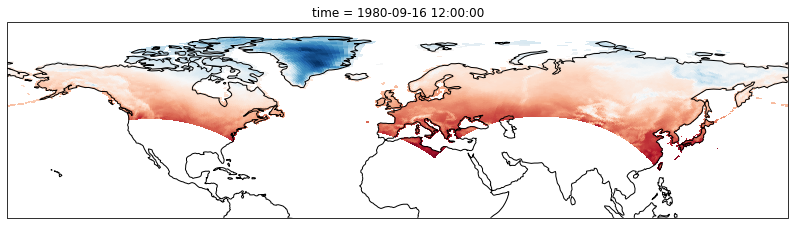

In [4]:
plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds.Tair[0].plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x='xc', y='yc', add_colorbar=False)
ax.coastlines()
ax.set_ylim([0,90]);


In [5]:
float(ds['xc'].min()), float(ds['xc'].max())

(0.0034942626682444296, 359.9998092651382)

In [6]:
ds['xc'] = ds['xc'].where(ds['xc'] < 180, ds['xc'] - 360)
float(ds['xc'].min()), float(ds['xc'].max())

(-179.99473432345633, 179.99690107148643)

In [7]:
store = tilecube.storage.HDF5TileCubeStorage('rasm_test.hdf5', mode='w')
store.open()
store

HDF5TileCubeStorage referencing: rasm_test.hdf5
No zoom levels initialized.

In [8]:
tc = tilecube.from_grid(ds['yc'], ds['xc'], storage=store)
tc

TileCube object with input grid dimensions: y=(205, 275), x=(205, 275)
References storage object: 
	HDF5TileCubeStorage referencing: rasm_test.hdf5
	No zoom levels initialized.

In [9]:
tc.generate_zoom_level_tilers(0, 'nearest_s2d')

100%|██████████| 1/1 [00:06<00:00,  6.13s/it]


In [10]:
tc

TileCube object with input grid dimensions: y=(205, 275), x=(205, 275)
References storage object: 
	HDF5TileCubeStorage referencing: rasm_test.hdf5
		Z=0: 1 / 1 tiles exist, 0 missing.
	

In [11]:
store.close()

In [12]:
store = tilecube.storage.HDF5TileCubeStorage('rasm_test.hdf5')
store.open()
tc = tilecube.from_storage(store)
tc.generate_zoom_level_tilers(1, 'nearest_s2d')
tc

 25%|██▌       | 1/4 [00:00<00:01,  2.87it/s]/Users/aron/opt/anaconda3/envs/sci-tiler/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


TileCube object with input grid dimensions: y=(205, 275), x=(205, 275)
References storage object: 
	HDF5TileCubeStorage referencing: rasm_test.hdf5
		Z=0: 1 / 1 tiles exist, 0 missing.
		Z=1: 2 / 4 tiles exist, 0 missing.
	

You can also generate all the tilers for a range of zoom levels by passing a list to `generate_zoom_level_tilers`.

Remember, the number of tiles go up as the square of the zoom level, so in that sense the runtime will go up exponentially. This is somewhat mitigated by the fact that the smaller tiles at higher zoom levels have less data to compute weight matrices for, so the calculation of an individual tile is somewhat faster (though this is only generally true, not necessarily in all cases or for all zoom levels). 


In [13]:
tc.generate_zoom_level_tilers(range(2, 6), 'nearest_s2d')
tc

100%|██████████| 48/48 [00:41<00:00,  1.17it/s]


TileCube object with input grid dimensions: y=(205, 275), x=(205, 275)
References storage object: 
	HDF5TileCubeStorage referencing: rasm_test.hdf5
		Z=0: 1 / 1 tiles exist, 0 missing.
		Z=1: 2 / 4 tiles exist, 0 missing.
		Z=2: 2 / 16 tiles exist, 0 missing.
		Z=3: 4 / 64 tiles exist, 0 missing.
		Z=4: 12 / 256 tiles exist, 0 missing.
		Z=5: 33 / 1024 tiles exist, 0 missing.
	

The number of tiles calculated at each zoom level might be a bit confusing. An important optimization of TileCube is that `Tilers` are only calculated and stored when a tile intersects the source data grid. At higher zoom levels, the fraction of tiles which intersect the grid will go down as the smaller tiles more accurately follow the boundary of the source grid edge. This may happen abruptly in the case of data which is rectangular in the web-mercator projection. 

When a subsequent zoom level is calculated, the starting point is the zoom level above - the "parent" zoom level. Remember that each tile in the parent level is split into four children tiles. If the parent tile doesn't intersect the source data grid, then we know that the children won't either so we don't even need to try to calculate them. 

Don't forget that the `TileCubeStore` we are working with is backed by an HDF5 File, so we need to close the store when we're done with it:

In [14]:
store.close()

In [16]:
m = Map(basemap=basemaps.OpenStreetMap.Mapnik, zoom=0)
layer = TileLayer(url='http://localhost:5000/0/{z}/{x}/{y}.png')
m.add_layer(layer)

def update_time(change):
    url = 'http://localhost:5000/' + str(time_slider.value) + '/{z}/{x}/{y}.png'
    print(url)
    layer.url = url

time_slider = IntSlider(description='Time Step:', min=0, max=25, value=0)
time_slider.observe(update_time, 'value')
# jslink((time_slider, 'value'), (layer, 'url'))
time_control = WidgetControl(widget=time_slider, position='topright')
m.add_control(time_control) 

m

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [17]:
store.close()

HDF5TileCubeStorage referencing: rasm_test.hdf5
No zoom levels initialized.